In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample data (use your own)
# t: shape (N, 1), targets: shape (N, 2)
t = torch.linspace(0, 2, steps=100).unsqueeze(1)  # (100, 1)
v0x, v0y, g = 5.0, 10.0, 9.8
sx = v0x * t
sy = v0y * t - 0.5 * g * t ** 2
targets = torch.cat([sx, sy], dim=1)  # (100, 2)

In [183]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 2)
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(t)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

In [184]:
preds = model(t).detach().numpy()

In [185]:
sorted_indices = torch.argsort(t.squeeze())

In [186]:
pred_x = outputs[sorted_indices, 0] 
pred_y = outputs[sorted_indices, 1]

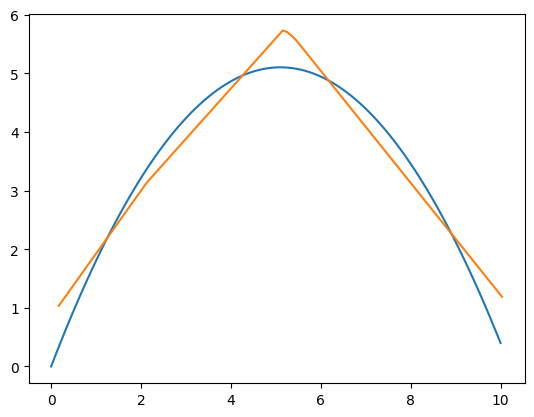

In [187]:
plt.plot(sx, sy)
plt.plot(pred_x.detach(), pred_y.detach())

# Coffee Cup example

In [263]:
T_env = 90
T_0 = 150
r = .5

def f(t,T):
    return .05*(T_env - r)

def T(t):
    return (T_0 - T_env)*np.exp(-r*t) + T_env

time_space = np.linspace(start=0, stop=10, num=1000)
t_given = time_space[:100]
T_true = np.array([T(t) for t in time_space])
T_given = np.array([T(t) for t in t_given])

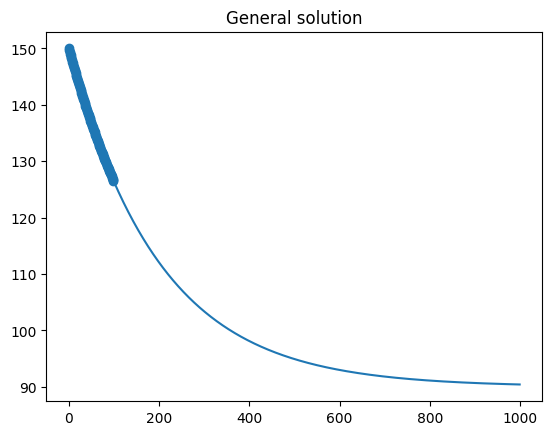

In [264]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')

In [283]:
torch.tensor(t_given).float().reshape(100,1)

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0501],
        [0.0601],
        [0.0701],
        [0.0801],
        [0.0901],
        [0.1001],
        [0.1101],
        [0.1201],
        [0.1301],
        [0.1401],
        [0.1502],
        [0.1602],
        [0.1702],
        [0.1802],
        [0.1902],
        [0.2002],
        [0.2102],
        [0.2202],
        [0.2302],
        [0.2402],
        [0.2503],
        [0.2603],
        [0.2703],
        [0.2803],
        [0.2903],
        [0.3003],
        [0.3103],
        [0.3203],
        [0.3303],
        [0.3403],
        [0.3504],
        [0.3604],
        [0.3704],
        [0.3804],
        [0.3904],
        [0.4004],
        [0.4104],
        [0.4204],
        [0.4304],
        [0.4404],
        [0.4505],
        [0.4605],
        [0.4705],
        [0.4805],
        [0.4905],
        [0.5005],
        [0.5105],
        [0.5205],
        [0.5305],
        [0.5405],
        [0

In [384]:
class PINNLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0]
    
    def physical_loss(self, model, ts):
        ts = ts.clone().detach().requires_grad_(True)
        inputs = ts
        outputs = model(ts)
        df_dt = self.grad(outputs=outputs, inputs=inputs)
        loss_term = df_dt - r*(T_env - outputs)
        return torch.mean(loss_term**2)
    
    def forward(self, model, ts, t_given, T_given):
        loss = torch.mean((model(t_given)[0] - T_0)**2) + self.physical_loss(model, ts)
        return loss

In [385]:
targets = T_given

model = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

criterion = PINNLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(torch.tensor(t_given).float().reshape(100,1))
    loss = criterion(model=model,
                     ts=torch.tensor(time_space).float().reshape(1000,1),
                     t_given=torch.tensor(t_given).float().reshape(100,1),
                     T_given=T_given)
    loss.backward()
    optimizer.step()

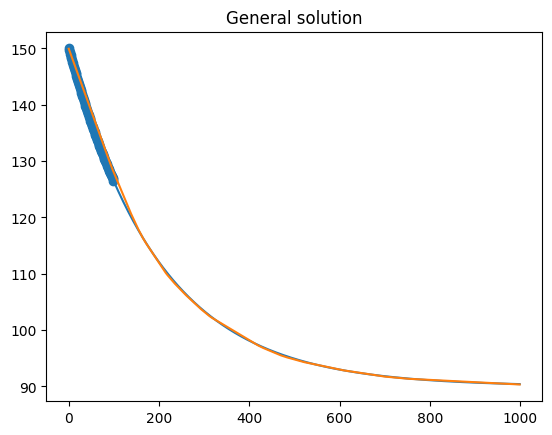

In [386]:
plt.plot(T_true)
plt.title("General solution")
plt.scatter(x=[t_given*100], y=T_given, marker='o')
plt.plot(model(torch.tensor(time_space).float().reshape(1000,1)).detach().numpy())

# Introduce heat equation (refine stability condition)

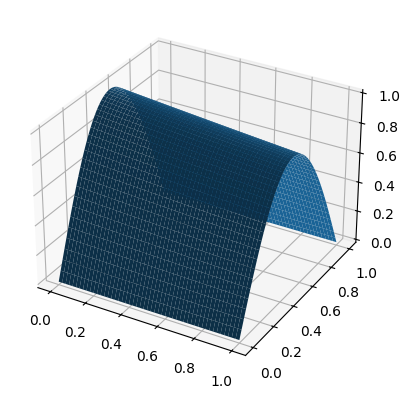

In [4]:
def IC(x):
    return np.sin(np.pi*x)

u_0 = u_L = 0
time_mesh = np.linspace(start=0, stop=1, num=10000)
spatial_mesh = np.linspace(start=0, stop=1, num=200)
ic = np.array([IC(x) for x in spatial_mesh])
k = .05

u = np.zeros((200,10000))
u[:,0] = ic
u[0,:] = u_0
u[-1,:] = u_L

for n in range(0, len(time_mesh) - 1):
    for j in range(1, len(spatial_mesh) - 1):
        u[j, n+1] = u[j, n] + k * (u[j+1, n] - 2*u[j, n] + u[j-1,n])

X, Y = np.meshgrid(spatial_mesh, time_mesh)  # shape = (10000, 1000)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Y, X, u.T)
plt.show()

In [6]:
u.max()

0.9999688468941563

# Introduce a PINN

In [4]:
X, T = np.meshgrid(spatial_mesh, time_mesh)

In [5]:
collocation_points = np.vstack([X.ravel(), T.ravel()]).T  # shape (5000, 2)
xs = spatial_mesh
ts = time_mesh

In [94]:
class PINN1DHeatLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.boundary = 2

    def initial_condiition(self, x):
        return np.sin(np.pi*x)

    def du_dt_grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0][:,1]
    
    def du_dx_grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0][:,0]
    
    def d2u_dx2_grad(self, outputs, inputs):
        du_dx = torch.autograd.grad(
            outputs=outputs,
            inputs=inputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True, 
            retain_graph=True
        )[0][:,0]

        d2u_dx2 = torch.autograd.grad(
            outputs=du_dx,
            inputs=inputs,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True, 
            retain_graph=True
        )[0][:,0]

        return d2u_dx2
    
    def physical_loss(self, model, ts, xs, mesh_points):
        ts = torch.tensor(ts).clone().detach().requires_grad_(True)
        xs = torch.tensor(xs).clone().detach().requires_grad_(True)
        inputs = torch.tensor(mesh_points, requires_grad=True).float()
        outputs = model(inputs)
        d2u_dx2 = self.d2u_dx2_grad(outputs=outputs, inputs=inputs)
        du_dt = self.du_dt_grad(outputs=outputs, inputs=inputs)
        loss_term = torch.mean((du_dt - d2u_dx2)**2)
        return loss_term
    
    def ic_loss(self, model, xs, ts):
        xs = torch.tensor(xs).float()
        ts = torch.tensor(np.array([0 for _ in range(len(xs))])).float()
        ic = torch.tensor(np.array([self.initial_condiition(x) for x in xs])).float()
        xt = torch.stack((xs, ts), dim=1)
        ic_pred = model(xt)
        return torch.mean((ic_pred - ic)**2)

    def bc_loss(self, model, ts): 
        xs_0 = torch.tensor(np.array([0 for _ in range(len(ts))])).float()
        xs_L = torch.tensor(np.array([1 for _ in range(len(ts))])).float()
        xt_0 = torch.stack([xs_0, torch.tensor(ts).float()], dim=1)
        xt_L = torch.stack([xs_L, torch.tensor(ts).float()], dim=1)
        bc_pred = torch.mean((model(xt_0) + model(xt_L))**2)
        return bc_pred

    def forward(self, model, xs, ts, mesh_points):
        loss = self.physical_loss(model=model, ts=ts, xs=xs, mesh_points=mesh_points) + self.ic_loss(model=model, xs=xs, ts=ts) + self.bc_loss(model=model, ts=ts)
        return loss

In [1]:
max(spatial_mesh)

NameError: name 'spatial_mesh' is not defined

In [96]:
pinn = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

criterion = PINN1DHeatLoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=.01)

for epoch in range(100):
    print(epoch)
    optimizer.zero_grad()
    outputs = pinn(torch.tensor(collocation_points).float())
    print(max(outputs))
    loss = criterion(pinn, xs, ts, mesh_points=collocation_points)
    loss.backward()
    optimizer.step()

0
tensor([0.4850], grad_fn=<UnbindBackward0>)
1
tensor([0.3238], grad_fn=<UnbindBackward0>)
2
tensor([0.1894], grad_fn=<UnbindBackward0>)
3
tensor([0.1163], grad_fn=<UnbindBackward0>)
4
tensor([0.1053], grad_fn=<UnbindBackward0>)
5
tensor([0.1324], grad_fn=<UnbindBackward0>)
6
tensor([0.1784], grad_fn=<UnbindBackward0>)
7
tensor([0.2300], grad_fn=<UnbindBackward0>)
8
tensor([0.2761], grad_fn=<UnbindBackward0>)
9
tensor([0.3077], grad_fn=<UnbindBackward0>)
10
tensor([0.3195], grad_fn=<UnbindBackward0>)
11
tensor([0.3127], grad_fn=<UnbindBackward0>)
12
tensor([0.2914], grad_fn=<UnbindBackward0>)
13
tensor([0.2617], grad_fn=<UnbindBackward0>)
14
tensor([0.2298], grad_fn=<UnbindBackward0>)
15
tensor([0.2018], grad_fn=<UnbindBackward0>)
16
tensor([0.1824], grad_fn=<UnbindBackward0>)
17
tensor([0.1747], grad_fn=<UnbindBackward0>)
18
tensor([0.1792], grad_fn=<UnbindBackward0>)
19
tensor([0.1941], grad_fn=<UnbindBackward0>)
20
tensor([0.2163], grad_fn=<UnbindBackward0>)
21
tensor([0.2417], gra

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107237a90>>
Traceback (most recent call last):
  File "/Users/benstager/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


tensor([0.2593], grad_fn=<UnbindBackward0>)
29
tensor([0.2415], grad_fn=<UnbindBackward0>)
30


: 

: 

In [83]:
collocation_points.shape

(2000000, 2)

In [81]:
outputs.shape

torch.Size([2000000, 1])

In [86]:
x = collocation_points[:, 0].reshape((len(time_mesh), len(spatial_mesh)))
t = collocation_points[:, 1].reshape((len(time_mesh), len(spatial_mesh)))
u = outputs.detach().numpy().reshape((len(time_mesh), len(spatial_mesh)))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, t, u, cmap='coolwarm', rstride=1, cstride=1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Model Output Surface')
plt.show()

KeyboardInterrupt: 

In [93]:
max(outputs)

tensor([-63.6678], grad_fn=<UnbindBackward0>)